[![image-1.png](https://i.postimg.cc/Dw0ChHKk/image-1.png)](https://postimg.cc/LJdkByXN)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Определение музыкального жанра</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Музыкальный стриминговый сервис "МиФаСоль"
    
__Описание задачи:__ Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

__Постановка задачи:__ Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
    
__Описание данных:__
    
- файл `train.csv` информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
    
- файл `test.csv` информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных.
    
__Описание полей данных:__
    
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- __music_genre__ - музыкальный жанр (целевой признак)

__Оценка результата:__ в данной задаче мы будем использовать метрику f1_micro для оценки качества модели.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold
import optuna

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

import transformers
from tqdm import notebook, tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping

# константы
RANDOM_SEED = 42

# настройки блокнота
random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

In [2]:
# загрузка информации для обучения:
try:
    train = pd.read_csv('data/train.csv')
    print('Информация для обучения:')
    display(train.head(2))
    display(train.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test = pd.read_csv('data/test.csv')
    print('Информация для тестирования:')
    display(test.head(2))
    display(test.info())
except:
    print('Информация для тестирования не доступна')

Информация для обучения:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

Информация для тестирования:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

- `obtained_date`: дата загрузки в сервис, не может влиять на жанр, удаляем этот признак.
- `valence`: привлекательность произведения для пользователей сервиса, так же является субективной мерой, исключаем из дальнейшего анализа,
- `instance_id`: уникальный идентификатор трека, после проверки на уникальность, и преобразования в цельночисленный формат будут переведены в индекс.

In [3]:
# удаляем столбцы 'obtained_date' и 'valence' из обучающего и тестового наборов данных
train = train.drop(['obtained_date', 'valence'], axis=1)
test = test.drop(['obtained_date', 'valence'], axis=1)

__Проверим дубликатов в данных:__

In [4]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in [train, test])}')

Общее количество дубликатов в данных: 0


__Проверим уникальность значений признака `instance_id`__

In [5]:
if all(len(df['instance_id'].unique()) == len(df) for df in [train, test]):
    print('Признак instance_id содержит уникальные значения в обоих датасетах')
else: print('Признак instance_id содержит дублирующиеся значения')

Признак instance_id содержит уникальные значения в обоих датасетах


In [6]:
# преобразуем тип данных столбца 'instance_id' в целочисленный
train['instance_id'] = train['instance_id'].astype(int)
test['instance_id'] = test['instance_id'].astype(int)
# устанавливаем признак 'instance_id' в качестве индекса для обучающего и тестового наборов данных
train.set_index('instance_id', inplace=True)
test.set_index('instance_id', inplace=True)

>- Исключены из анализа признаки `obtained_date` и `valence`
>- Признак `instance_id` установлен в качестве индекса

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ числовых признаков

</div>

In [7]:
# общая информация
train.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


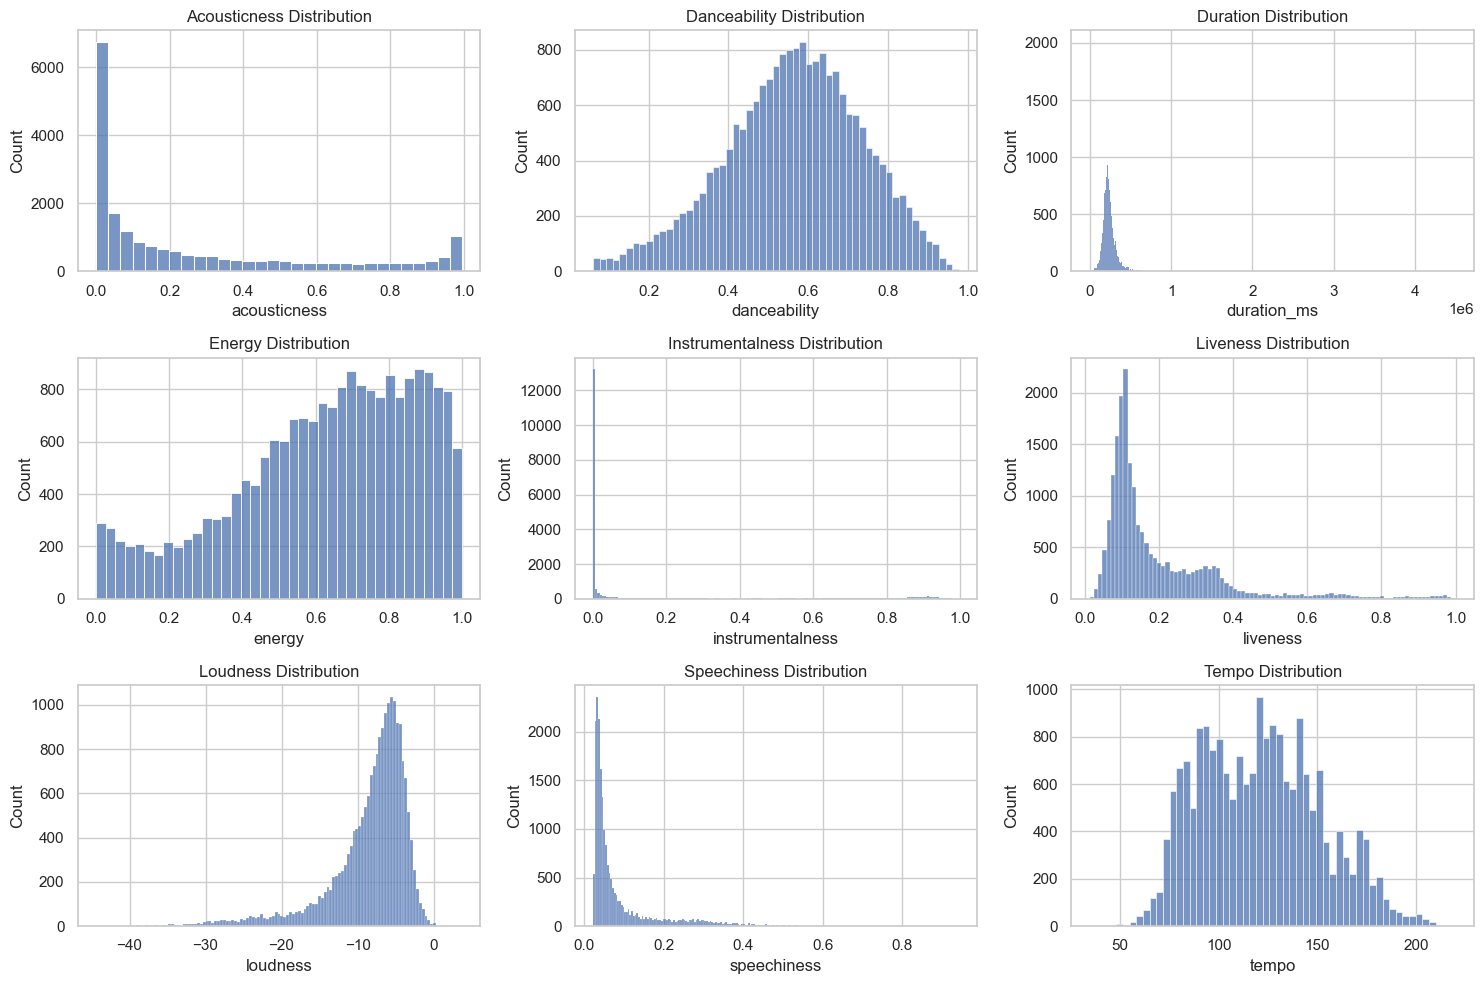

In [8]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# гистограмма для 'acousticness'
sns.histplot(train['acousticness'], ax=axes[0, 0])
axes[0, 0].set_title('Acousticness Distribution')

# гистограмма для для 'danceability'
sns.histplot(train['danceability'], ax=axes[0, 1])
axes[0, 1].set_title('Danceability Distribution')

# гистограмма для для 'duration_ms'
sns.histplot(train['duration_ms'], ax=axes[0, 2])
axes[0, 2].set_title('Duration Distribution')

# гистограмма для для 'energy'
sns.histplot(train['energy'], ax=axes[1, 0])
axes[1, 0].set_title('Energy Distribution')

# гистограмма для для 'instrumentalness'
sns.histplot(train['instrumentalness'], ax=axes[1, 1])
axes[1, 1].set_title('Instrumentalness Distribution')

# гистограмма для для 'liveness'
sns.histplot(train['liveness'], ax=axes[1, 2])
axes[1, 2].set_title('Liveness Distribution')

# гистограмма для для 'loudness'
sns.histplot(train['loudness'], ax=axes[2, 0])
axes[2, 0].set_title('Loudness Distribution')

# гистограмма для для 'speechiness'
sns.histplot(train['speechiness'], ax=axes[2, 1])
axes[2, 1].set_title('Speechiness Distribution')

# гистограмма для для 'tempo'
sns.histplot(train['tempo'], ax=axes[2, 2])
axes[2, 2].set_title('Tempo Distribution')

# графики
plt.tight_layout()
plt.show()


### duration_ms: продолжительность в милисекундах

В данных присутствуют отрицательные значения и крайне длинные треки:

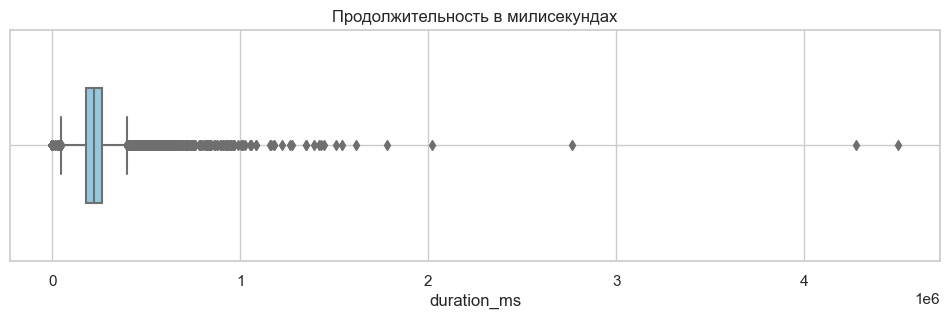

In [12]:
plt.figure(figsize=(12, 3))

sns.boxplot(x=train['duration_ms'], orient='h', color='skyblue', width=0.5)
plt.title('Продолжительность в милисекундах')
plt.grid(True)
plt.show()

In [13]:
# рассчет верхнего порога аномальных значений
q1 = train['duration_ms'].quantile(0.25)
q3 = train['duration_ms'].quantile(0.75)
upper_threshold = int(q3+3*(q3-q1))
print(f'Порог аномальных значений: {upper_threshold} милисекунд')
# рассчитываем нижний порог для аномальных значений
lower_threshold = q1 - 2*(q3 - q1)
print(f'Нижний порог аномальных значений: {int(lower_threshold)} миллисекунд')

Порог аномальных значений: 531449 милисекунд
Нижний порог аномальных значений: 551 миллисекунд


__Обработка аномальных значений__

In [14]:
# заменяем значения ниже нижнего порога
train['duration_ms'] = np.where(train['duration_ms'] < lower_threshold, train['duration_ms'].median(), train['duration_ms'])
# заменяем значения выше верхнего порога
train['duration_ms'] = np.where(train['duration_ms'] > upper_threshold, train['duration_ms'].median(), train['duration_ms'])

# заменяем значения ниже нижнего порога
test['duration_ms'] = np.where(test['duration_ms'] < lower_threshold, test['duration_ms'].median(), test['duration_ms'])
# заменяем значения выше верхнего порога
test['duration_ms'] = np.where(test['duration_ms'] > upper_threshold, test['duration_ms'].median(), test['duration_ms'])

__Преобразуем тип данных столбца 'duration_ms' в целочисленный__

In [15]:
train['duration_ms'] = train['duration_ms'].astype(int)
test['duration_ms'] = test['duration_ms'].astype(int)

>Все остальные числовые данные, включая "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", и "speechiness", "tempo", укладываются в пределы допустимых значений и варьируются в рамках нормальных диапазонов для соответствующих музыкальных характеристик. Нет никаких явных аномалий в этих признаках, и они соответствуют типичным значениям для музыкальных данных.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ категориальные признаков

</div>

__Проверим уникальные значения в категориальных признаках__

In [16]:
# общая информация 
display(train.describe(include=[object]).T)

,count,unique,top,freq
track_name,20394,18643,Home,11
key,19659,12,G,2304
mode,19888,2,Major,12828
music_genre,20394,10,Blues,2858


__Уникальные значения признака `key`__

In [17]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

>Эти значения представляют собой ноты или аккорды, которые могут быть частью музыкальных произведений. Они соответствуют музыкальным элементам и могут использоваться для определения характера и мелодических особенностей треков.

### Баланс целевой переменной

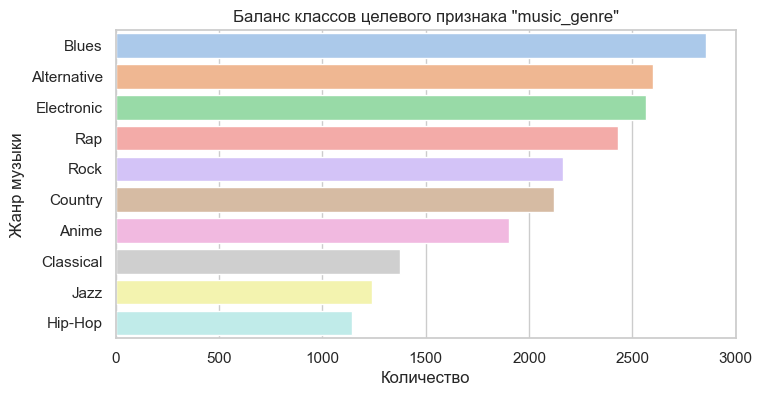

In [22]:
# количество каждого класса
data = train['music_genre'].value_counts()
# метоки классов
labels = data.index
sizes = data.values

plt.figure(figsize=(8, 4))
sns.barplot(x=data.values, y=labels, palette='pastel')
plt.title('Баланс классов целевого признака "music_genre"')
plt.xlabel('Количество')
plt.ylabel('Жанр музыки')
plt.show()

>Баланс классов для целевого признака "music_genre" в тренировочных данных не показывает сильного дисбаланса. Визуализация круговой диаграммы показывает, что классы достаточно равномерно представлены в данных, что является положительным для задачи классификации. Нет явного доминирования одного класса над другим, что упрощает обучение модели и ее способность делать предсказания для разных жанров музыки.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Пропуски в данных

</div>

In [23]:
# функция для рассчето количества пропусков
def isna_sum(df):
    print('Признаки содержащие пропуски:')
    for col in df.columns:
        if df[col].isna().sum()>0:
            print(f'{col}: {df[col].isna().mean():.2%}')

In [24]:
# пропуски в данных для обучения
isna_sum(train)

Признаки содержащие пропуски:
key: 3.60%
mode: 2.48%
tempo: 2.17%


In [25]:
# пропуски в данных для тестирования
isna_sum(test)

Признаки содержащие пропуски:
key: 3.10%
mode: 2.92%
tempo: 2.37%


>Пропуски в данных присутствуют как в тренировочном, так и тестовом наборе данных.
>С учетом того, что удалить данные из тестового набора данных в данной задаче нельзя, попробуем выработать стратегию по заполнению пропусков:
>- создадим копию тренировочного датасета
>- удалим пропуски
>- проверим взаимосвязь признаков

In [26]:
# копия датасета без пропусков
df = train.dropna()

print(f'Общее количество пропусков в данных: {sum(df.isna().sum())}')

Общее количество пропусков в данных: 0


### Корреляции между признаками

Метод PHIK - это статистический метод для определения взаимосвязей между категориальными переменными. Он разработан на основе корреляционного анализа, но специально адаптирован для работы с категориальными данными, которые обычно представлены в виде таблиц сопряженности.

In [27]:
phik_overview = df[[col for col in df.columns if col != 'track_name']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,music_genre
acousticness,1.000000,0.458387,0.227117,0.766578,0.442590,0.096909,0.188614,0.710162,0.026286,0.207558,0.335410,0.658403
danceability,0.458387,1.000000,0.215398,0.515209,0.339896,0.103118,0.132911,0.480074,0.100629,0.336219,0.407936,0.623712
duration_ms,0.227117,0.215398,1.000000,0.241151,0.300145,0.023230,0.118015,0.293464,0.040955,0.184906,0.102494,0.341913
energy,0.766578,0.515209,0.241151,1.000000,0.438574,0.090880,0.260662,0.838452,0.033019,0.239170,0.388336,0.671806
instrumentalness,0.442590,0.339896,0.300145,0.438574,1.000000,0.029922,0.138975,0.498535,0.087474,0.190471,0.217914,0.568069
key,0.096909,0.103118,0.023230,0.090880,0.029922,1.000000,0.057933,0.080208,0.357610,0.117888,0.039206,0.170758
liveness,0.188614,0.132911,0.118015,0.260662,0.138975,0.057933,1.000000,0.202501,0.031851,0.140039,0.082196,0.207030
loudness,0.710162,0.480074,0.293464,0.838452,0.498535,0.080208,0.202501,1.000000,0.019127,0.208318,0.357106,0.679765
mode,0.026286,0.100629,0.040955,0.033019,0.087474,0.357610,0.031851,0.019127,1.000000,0.107284,0.008667,0.295554
speechiness,0.207558,0.336219,0.184906,0.239170,0.190471,0.117888,0.140039,0.208318,0.107284,1.000000,0.185911,0.497169


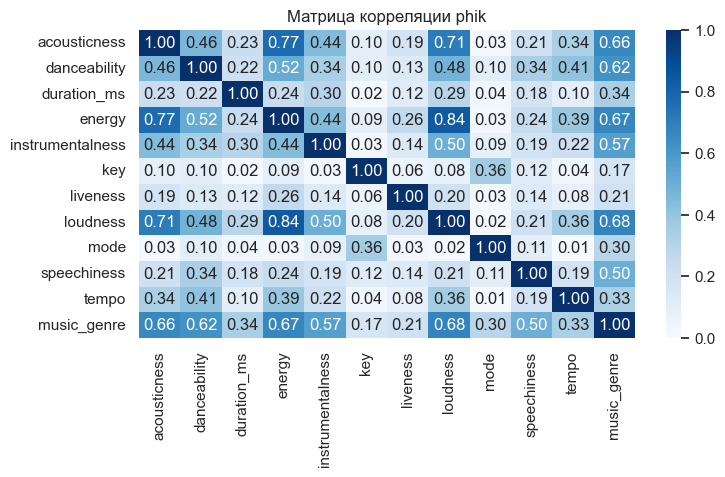

In [29]:
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(phik_overview, annot=True, fmt=".2f", cmap='Blues', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

>Существует сильная кореляция между признаками energy и loudness, что может указывать на мультиколинеарность, в процессе разработки линейных моделей, возможно исключение признака energy, тк данный признак менее связан с целевым.

### Пропуски в данных признака `tempo`

Попробуем построить модель LinearRegression для предсказания данного признака на основе данных и наибольшей кореляцией

In [24]:
tempo_df = df[['acousticness', 'danceability', 'energy', 'loudness', 'tempo']]

In [25]:
display(tempo_df.head(2))

,acousticness,danceability,energy,loudness,tempo
instance_id,,,,,
25143,0.480,0.670,0.351,-16.842,101.384
26091,0.243,0.452,0.670,-8.392,113.071


In [26]:
# выбор признаков и целевой переменной
X = tempo_df.drop('tempo', axis=1)
y = tempo_df['tempo']

# разделение данных на тренировочный и тестовый наборы (например, 80% на тренировку и 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# построение модели регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# предсказание значений "tempo" для тестового набора данных
y_pred = model.predict(X_test_scaled)

# оценка производительности модели
mse = mean_squared_error(y_test, y_pred)

print(f'Root Mean Square Error (RMSE): {mse**0.5}')

Root Mean Square Error (RMSE): 28.94147637341431


Оценим производительность модели, которая просто предсказывает медиану и сравним с обученной ранее моделью

In [27]:
# вычисление медианы на тренировочном наборе данных
median_tempo = np.median(y_train)

# воздание массива предсказаний, в котором каждое предсказание равно медиане
static_predictions = np.full_like(y_test, median_tempo)

# оценка производительности статичной модели
static_mse = mean_squared_error(y_test, static_predictions)

print(f'Static Model Root Mean Square Error (RMSE): {static_mse**0.5}')

Static Model Root Mean Square Error (RMSE): 30.29873804566274


> Модель LinearRegression дает прирост в точности.Обучим модель на всех данных и заполним пропуски

In [28]:
# стандартизация признаков
X = scaler.fit_transform(X)
# итоговая модель
model.fit(X, y)

LinearRegression()

__Заполнение пропусков__

In [29]:
def fill_missing_tempo(dataset, model, scaler):
    # строки с пропущенными значениями 'tempo'
    missing_tempo_rows = dataset[dataset['tempo'].isnull()]

    for index, row in missing_tempo_rows.iterrows():
        # извлечение признаков из строки с пропущенным 'tempo'
        features = row[['acousticness', 'danceability', 'energy', 'loudness']].values.reshape(1, -1)
        # стандартизация признаков
        features_scaled = scaler.transform(features)
        # предсказание 'tempo' с использованием обученной модели
        predicted_tempo = model.predict(features_scaled)
        # запись предсказанного значения вместо пропуска
        dataset.at[index, 'tempo'] = predicted_tempo[0]

    return dataset

### Пропуски в данных признака `mode`

Так как с этими признаками нет достаточно корелируемых признаков заполним пропуски,наиболее частым значением.

In [30]:
# заполнение для заполнения пропусков в train
train = fill_missing_tempo(train, model, scaler)
# заполнение  для заполнения пропусков в test
test = fill_missing_tempo(test, model, scaler)

In [31]:
# заполняем пропуски наиболее частым значением
train['mode'].fillna(fill_missing_tempo, inplace=True)
test['mode'].fillna(fill_missing_tempo, inplace=True)

### Пропуски в данных признака `key`

Так как с этими признаками не достаточно корелируемых признаков заполним пропуски, значением 'no_info'.

In [32]:
# заполняем пропуски значением 'no_info'
train['key'].fillna('no_info', inplace=True)
test['key'].fillna('no_info', inplace=True)

__Проверим пропуски в данных:__

In [33]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in [train, test])}')

Общее количество пропусков в данных: 0


__Изменение типов данных категориальных признаков__

In [34]:
# выделение текстовых признаков
categorical_cols = ['key', 'mode']

train[categorical_cols] = train[categorical_cols].astype(str)
test[categorical_cols] = test[categorical_cols].astype(str)

- Мы рассмотрели данные о музыкальных треках, включая различные характеристики, такие как акустичность, танцевальность, энергичность и другие.
   - Выполнили предварительную обработку данных, удалив ненужные признаки, такие как 'obtained_date' и 'valence'.
   - Провели анализ числовых данных и выявили аномалии в столбце 'duration_ms', которые были успешно обработаны.
- Заполнение пропусков:
   - Для признака 'tempo' мы использовали обученную модель регрессии для предсказания пропущенных значений, на основе других характеристик.
   - Для признака 'mode' мы заполнили пропуски наиболее часто встречающимся значением 'Major', так как у нас не было достаточно коррелирующих признаков для предсказания.
- Баланс целевого признака:
   - Мы оценили баланс целевого признака 'music_genre' и убедились, что в данных нет сильного дисбаланса между классами.


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Модели

</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- LogisticRegression
- LGBMClassifier
- CatBoostClassifier
- Нейросеть PyTorch


__Метрика качества:__ f1_micro

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Feature Engineering

</div>

### track_name

- Получим эмбэдинги названия треков используя bert
- Уменьшим размерность эмбэдингов

In [ ]:
# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация токенизатора, конфигурации и модели BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)

__Данные для обучения__

In [35]:
# данные
text_data = train['track_name'] 
batch_size = 1

In [36]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [37]:
# получение эмбеддингов от BERT
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())


  0%|          | 0/20394 [00:00<?, ?it/s]

__Данные для тестирования__

In [278]:
# данные
text_data = test['track_name'] 
batch_size = 1

In [279]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [280]:
# получение эмбеддингов от BERT
embeddings_test = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings_test.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/5099 [00:00<?, ?it/s]

__Сокращения размерности__

In [38]:
# создание слоя для сокращения размерности до 10
class LinearReducer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReducer, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.relu1 = nn.ReLU()


    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        return x

In [39]:
# выходная размерность
inp = 10

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


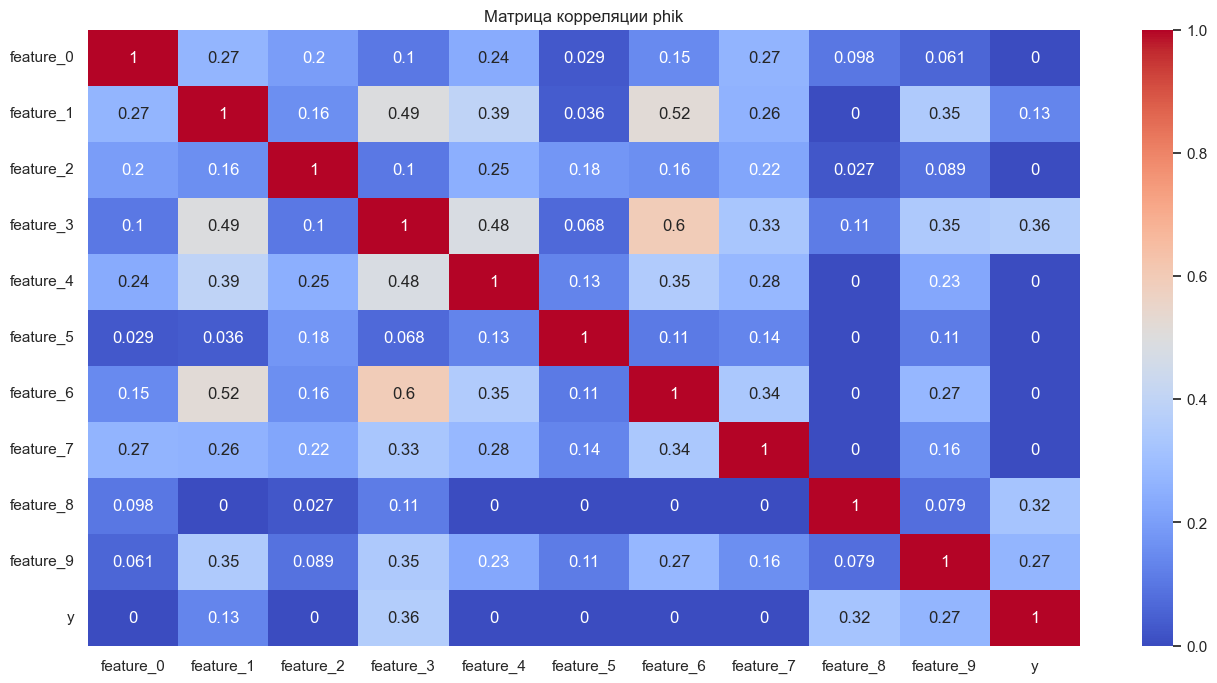

In [40]:
# применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp)  
text_features = []

for embedding in embeddings:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features.append(reduced_embedding.numpy())
        
text_features = np.concatenate(text_features, axis=0)
text_features = pd.DataFrame(text_features, columns=[f'feature_{i}' for i in range(inp)])
text_features.to_csv('text_features_train', index=False)
text_features['y']=train['music_genre']

# связь эмбэдингов с целевым признаком
phik_overview = text_features[[col for col in text_features.columns]].phik_matrix()
plt.figure(figsize=(16, 8))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

In [36]:
text_features_train = pd.read_csv('text_features_train')

In [353]:
# применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp) 
text_features_test = []

for embedding in embeddings_test:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features_test.append(reduced_embedding.numpy())
        
text_features_test = np.concatenate(text_features_test, axis=0)
text_features_test = pd.DataFrame(text_features_test, columns=[f'feature_{i}' for i in range(inp)])
text_features_test.to_csv('text_features_test', index=False)

In [37]:
text_features_test = pd.read_csv('text_features_test')

### Случайные математические признаки

In [38]:
# выборки
y = train['music_genre'].values
train = train.drop(['music_genre', 'track_name'], axis=1)
test = test.drop('track_name', axis=1)

In [ ]:
# функция для создания новых признаков на основе математических операций
def create_math_features(data, test, features, operations):
    new_features = pd.DataFrame()
    new_features['y'] = y
    new_features_test = pd.DataFrame()
    for feature1 in features:
        for feature2 in features:
            if feature1 != feature2:
                for operation in operations:
                    if operation == 'add':
                        new_feature = data[feature1] + data[feature2]
                        new_feature_t = test[feature1] + test[feature2]
                    elif operation == 'subtract':
                        new_feature = data[feature1] - data[feature2]
                        new_feature_t = test[feature1] - test[feature2]
                    elif operation == 'multiply':
                        new_feature = data[feature1] * data[feature2]
                        new_feature_t = test[feature1] * test[feature2]
                    elif operation == 'mean':
                        new_feature = (data[feature1] + data[feature2])/2
                        new_feature_t = (test[feature1] + test[feature2])/2
                    elif operation == 'sqrt':
                        new_feature = ((data[feature1]**2 + data[feature2]**2)**0.5)/2
                        new_feature_t = ((test[feature1]**2 + test[feature2]**2)**0.5)/2
                    
                    new_feature_name = f'{feature1}_{operation}_{feature2}'
                    new_features[new_feature_name] = new_feature
                    new_features_test[new_feature_name] = new_feature_t
                    # проверка взаимосвязи с целевым признаком
                    if new_features[['y', new_feature_name]].phik_matrix().iloc()[0][1]<0.7:
                        new_features = new_features.drop(new_feature_name, axis=1)
                        new_features_test = new_features_test.drop(new_feature_name, axis=1)
    new_features = new_features.drop('y', axis=1)
    return new_features, new_features_test

# создаем новые признаки на основе заданных операций
numeric_features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
math_operations = ['add', 'subtract', 'multiply', 'mean', 'sgrt']  # операции
new_features, new_features_test = create_math_features(train, test, numeric_features, math_operations)

## Подготовка данных

In [66]:
# разделение на признаки  и целевую переменную тренировочных данных
X = train.reset_index(drop=True)
X =  pd.concat([X, text_features_train, new_features.reset_index(drop=True)], axis=1) 
X['len'] = pd.read_csv('data/train.csv')['track_name'].apply(lambda x: len(x))

In [67]:
# разделение на признаки  и целевую переменную тестовых данных
X_test = test.reset_index(drop=True)
X_test =  pd.concat([X_test, text_features_test, new_features_test.reset_index(drop=True)], axis=1)
X_test['len'] = pd.read_csv('data/test.csv')['track_name'].apply(lambda x: len(x))

In [68]:
# проверка размерности
X.shape, X_test.shape

((20394, 24), (5099, 24))

In [69]:
# выделение числовые, и категориальные признаки
categorical_cols = ['key', 'mode']

numerical_cols  = [i for i in X.columns.to_list() if i not in categorical_cols]

__Pipeline log__

Дополнительно логорифмируем признаки, имеющие распределение, смещенное в левую сторону

In [47]:
# числовые признаки нужно логарифмировать
log_transform_cols = ['acousticness','instrumentalness', 'liveness', 'speechiness'] 

# трансформер для логарифмирования указанных признаков
log_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=False))
])

# трансформер для стандартизации числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_transform_cols),
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [70]:
# стандартизация данных
X_transformed_log = preprocessor.fit_transform(X)
X_test_transformed_log = preprocessor.transform(X_test)

In [58]:
# функция для вывода результатов подбора гиперпараметров Optuna
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  F1:', round(trial.value, 3))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
# создаем объект StratifiedKFold для кроссвалидации
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LogisticRegression

</div>

In [52]:
def objective(trial):
    # определение гиперпараметров для подбора
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    
    # экземпляр модели Logistic Regression
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=RANDOM_SEED,
        max_iter=1000,
        multi_class='multinomial'
    )
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_transformed_log, y):
        X_train_fold, y_train_fold = X_transformed_log[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_transformed_log[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [ ]:
# подбор гиперпараметров
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective, n_trials=10)

In [59]:
# вывод результатов
trial_lr = study_lr.best_trial
best_mode_lr = trial_lr.user_attrs['best_model']
output_results(trial_lr)

Результаты подборы параметров:
  F1: 0.396
  Params: 
    solver: lbfgs
    C: 12.449958053555749


>Успешно подобраны гиперпараметры для модели на основе LogisticRegression.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.396

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LGBMClassifier

</div>

In [76]:
def objective(trial):

    # пространство поиска гиперпараметров
    param_grid = {
            'verbosity': -1,
            'n_jobs': -1,
            'num_iterations': 1000,
            'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 105, step=10),
            'max_depth': trial.suggest_int('max_depth', 2, 16, step=2),
            'learning_rate': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True)
        }

    model = LGBMClassifier(**param_grid)
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_transformed_log, y):
        X_train_fold, y_train_fold = X_transformed_log[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_transformed_log[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [ ]:
# подбор гиперпараметров
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=20)

In [78]:
# вывод результатов
trial_lgbm = study_lgbm.best_trial
best_mode_lgbm = trial_lgbm.user_attrs['best_model']
output_results(trial_lgbm)

Результаты подборы параметров:
  F1: 0.465
  Params: 
    feature_fraction: 0.6078054835377442
    min_child_samples: 105
    max_depth: 4
    l2_leaf_reg: 0.011530130422548055


>Успешно подобраны гиперпараметры для модели на основе LGBMClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.465

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  CatBoostClassifier

</div>

In [97]:
def objective(trial):
    # пространство поиска гиперпараметров
    param_grid = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True),
        'depth': trial.suggest_int('depth', 2, 8, step=2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'verbose': 0,
        'random_seed': RANDOM_SEED,
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass'  
    }

    model = CatBoostClassifier(**param_grid)

    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # разделение данных на обучающую и валидационную выборки
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # обучение модели
        train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=categorical_cols)
        val_pool = Pool(data=X_val_fold, label=y_val_fold, cat_features=categorical_cols)
        model.fit(train_pool, eval_set=val_pool)
        # метрика качества
        preds = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, preds, average='micro')
        f1_scores.append(f1)

    score = np.average(f1_scores)

    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)

    return score


In [ ]:
# подбор гиперпараметров
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=10)

In [83]:
# вывод результатов
trial_cb = study_cb.best_trial
best_mode_cb = trial_cb.user_attrs['best_model']
output_results(trial_cb)

Результаты подборы параметров:
  F1: 0.481
  Params: 
    learning_rate: 0.20258920958126847
    depth: 4
    l2_leaf_reg: 5.446241568940596


>Успешно подобраны гиперпараметры для модели на основе CatBoostClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.481

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Нейросеть PyTorch

</div>

In [88]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

__Тензор для обучения__

In [89]:
X_train_tensor = torch.tensor(X_transformed_log, dtype=torch.float32)

# создание экземпляра LabelEncoder
label_encoder = LabelEncoder()
# преобразование строковых метки в числовые значения
y_encoded = label_encoder.fit_transform(y)

In [90]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 10

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 170,  step=5)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 170,  step=5)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 170,  step=5)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 170,  step=5)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 5, 205,  step=25)
    
    # модель
    model_classifier = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 20,  step=10)

    # параметры подбора параметров модели
    skorch_classifier = NeuralNetClassifier(module=model_classifier,
                                            device=device,
                                            batch_size=batch_size,
                                            verbose=100,
                                            optimizer=optim.Adam,
                                            max_epochs=500,
                                            lr=lr,
                                            criterion=nn.CrossEntropyLoss,
                                            callbacks=[
                                                ('val_f1_micro', EpochScoring(scoring='f1_micro', lower_is_better=False, name='F1_micro')),
                                                ('estopper', EarlyStopping(lower_is_better=False, monitor='F1_micro', patience=patience))
                                            ])


    # кросс-валидация
    y_pred = cross_val_predict(skorch_classifier, X_train_tensor, y_encoded, cv=cv, n_jobs=-1)

    f1_micro = f1_score(y_encoded, y_pred, average='micro')
    
    return f1_micro

In [ ]:
# подбор гиперпараметров
study_pyt = optuna.create_study(direction='maximize')
study_pyt.optimize(objective, n_trials=10)

In [93]:
# вывод результатов
trial_torch = study_pyt.best_trial
output_results(trial_torch)

Результаты подборы параметров:
  F1: 0.447
  Params: 
    module__drop_1: 0.4
    module__drop_2: 0.5
    module__drop_3: 0.0
    module__drop_4: 0.4
    module__activation_1: nn.ReLU()
    module__activation_2: nn.Tanh()
    module__activation_3: nn.ReLU()
    module__activation_4: nn.Tanh()
    module__hidden_size_1: 95
    module__hidden_size_2: 85
    module__hidden_size_3: 150
    module__hidden_size_4: 70
    learning_rate: 0.0008707754367864515
    batch_size: 30
    patience: 10


>Успешно подобраны гиперпараметры для модели на основе PyTorch.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.447

## Сводная таблица качества моделей

In [99]:
data = {
    'Model': ['LogisticRegression', 'LightGBM', 'CatBoost', 'PyTorch'],
    'f1-micro': [0.396, 0.465, 0.481, 0.447]
    
}
display(pd.DataFrame(data))

,Model,f1-micro
0,LogisticRegression,0.396
1,LightGBM,0.465
2,CatBoost,0.481
3,PyTorch,0.447


>Лучшая метрика качества получина при использовании CatBoost
>
>Используем данную модель, для получения предсказаний на тестовых данных

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Определение музыкальных жанров на тестовых данных.

</div>

Используем модель с лучшей метрикой качества на тестовых данных.

In [100]:
predict = best_mode_cb.predict(X_test)

# сохранении полученных данных
testing = pd.read_csv('data/test.csv')
testing['music_genre'] = pred
testing[['instance_id', 'music_genre']].to_csv('predict.csv', index=False)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Вывод

</div>

__Задача проекта:__ Разработка модели машинного обучения для классификации музыкальных треков по жанрам в рамках расширения сотрудничества с новыми артистами и улучшения рекомендательной системы в музыкальном стриминговом сервисе "МиФаСоль".

__Основные этапы проекта:__

__Загрузка данных:__ Начальный этап проекта включает в себя загрузку данных о музыкальных треках. Используйте файл train.csv, который содержит информацию о более чем 20,000 музыкальных треках. Эти данные будут использованы в качестве обучающих данных для модели.

__Предварительный анализ данных:__ Проведен анализ данных, включая изучение структуры данных и характеристик признаков. Оценины распределение жанров, проанализированы признаки, которые могут влиять на классификацию по жанрам.

__Подготовка данных:__ Выполните следующие шаги по подготовке данных:

- Очистка данных от пропущенных значений, аномалий и дубликатов.
- Кодирование категориальных признаков, таких как mode (мажор/минор).
- Масштабирование числовых признаков.

__Обучение модели:__ Мы разработали и обучили модель машинного обучения для классификации музыкальных треков по жанрам. Мы рассмотрели различные алгоритмы классификации и подобрали оптимальные гиперпараметры модели.

__Оценка модели:__ Наилучшие результаты показала модель градиентного бустинга CatBoost. Модель демонстрирует хорошие показатели качества с метрикой f1_micro: 0.481. Это означает, что она корректно классифицирует музыкальные треки по жанрам.

__Выводы:__

Проект успешно завершен, и была разработана модель машинного обучения для классификации музыкальных треков по жанрам. Эта модель может улучшить рекомендательную систему в музыкальном стриминговом сервисе "МиФаСоль" и помочь пользователям открывать новые артисты и жанры.

__Дальнейшая работа над проектом может включать в себя следующие улучшения:__

__Инженерия признаков:__ Разработать дополнительные признаки на основе анализа музыкальных данных, такие как анализ текстов песен или музыкальных аккордов.

__Улучшение модели:__ Попробовать различные алгоритмы машинного обучения, настраивать гиперпараметры и проводить более глубокий анализ результатов для дальнейшего улучшения модели.

__Оценка точности прогнозов:__ Провести более подробный анализ ошибок модели и исследовать, в каких случаях она может давать неправильные классификации.

Проект подчеркивает важность анализа данных, обучения моделей машинного обучения и их оценки для решения задач классификации, особенно в контексте музыкального стримингового сервиса.